# How to use prior knowledge in LiM

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [1]:
import os
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_prior_knowledge, make_dot

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.26.4', '2.2.2', '0.20.3', '1.9.0']


## Utility function
We define a utility function to draw the directed acyclic graph.

In [2]:
def make_prior_knowledge_graph(prior_knowledge_matrix):
    d = graphviz.Digraph(engine='dot')
    
    labels = [f'x{i}' for i in range(prior_knowledge_matrix.shape[0])]
    for label in labels:
        d.node(label, label)

    dirs = np.where(prior_knowledge_matrix > 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        d.edge(labels[from_], labels[to])

    dirs = np.where(prior_knowledge_matrix < 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        if to != from_:
            d.edge(labels[from_], labels[to], style='dashed')
    return d

## Test data
We create test data consisting of 6 variables.

In [3]:
cwd = os.getcwd()
X = np.loadtxt(f"{cwd}/../tests/test_lim_data.csv", delimiter=",")
dis_con = np.array([[0.0, 0.0, 0.0, 1.0, 1.0]])

X[:5,:]

array([[ 1.   ,  1.   ,  1.   ,  0.194,  0.388],
       [ 1.   ,  1.   ,  0.   ,  0.142, -1.475],
       [ 1.   ,  1.   ,  1.   , -0.061, -1.92 ],
       [ 1.   ,  1.   ,  1.   ,  0.612, -0.297],
       [ 1.   ,  1.   ,  1.   ,  0.331, -2.172]])

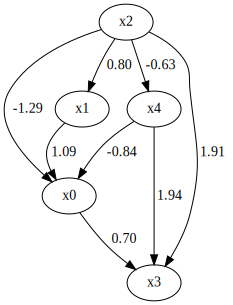

In [4]:
W_true = np.array(
    [ 
        [0.0, 1.09482609, -1.29270764, 0.0, -0.84424137],
        [0.0, 0.0, 0.80393307, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0],
        [0.70346053, 0.0, 1.90912441, 0.0, 1.94441713],
        [0.0, 0.0, -0.63152585, 0.0, 0.0],
    ]
)
make_dot(W_true)

## Make Prior Knowledge Matrix
We create prior knowledge so that x0, x1 and x4 are sink variables.

The elements of prior knowledge matrix are defined as follows:
* ``0`` : :math:`x_i` does not have a directed path to :math:`x_j`
* ``1`` : :math:`x_i` has a directed path to :math:`x_j`
* ``-1`` : No prior knowledge is available to know if either of the two cases above (0 or 1) is true.

In [5]:
prior_knowledge = make_prior_knowledge(
    n_variables=5,
    sink_variables=[0, 3],
)
print(prior_knowledge)

[[-1 -1 -1  0 -1]
 [ 0 -1 -1  0 -1]
 [ 0 -1 -1  0 -1]
 [ 0 -1 -1 -1 -1]
 [ 0 -1 -1  0 -1]]


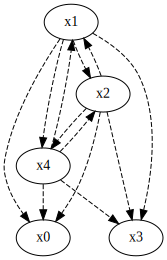

In [6]:
# Draw a graph of prior knowledge
make_prior_knowledge_graph(prior_knowledge)

## Causal Discovery
First, we create a `LiM` object without the prior knowledge matrix.

[[ 0.     0.495 -0.211  0.     0.   ]
 [ 0.     0.     0.388  0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [-0.119 -0.408  1.     0.     0.995]
 [-0.365 -0.422 -0.254  0.     0.   ]]


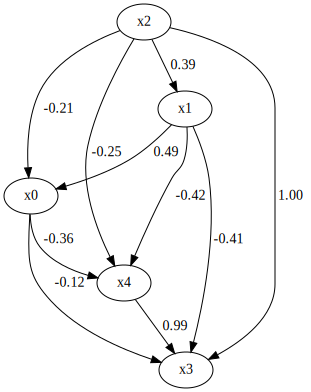

In [7]:
model = lingam.LiM()
model.fit(X, dis_con)
print(model.adjacency_matrix_)
make_dot(model.adjacency_matrix_)

### x0, x3 as sink variables

[[-1 -1 -1  0 -1]
 [ 0 -1 -1  0 -1]
 [ 0 -1 -1  0 -1]
 [ 0 -1 -1 -1 -1]
 [ 0 -1 -1  0 -1]]
[[ 0.     0.41   0.743  0.     1.   ]
 [ 0.     0.     0.     0.     1.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.361  0.     0.951]
 [ 0.     0.    -1.066  0.     0.   ]]


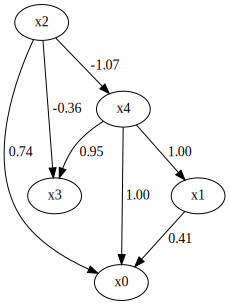

In [8]:
prior_knowledge = make_prior_knowledge(
    n_variables=5,
    sink_variables=[0, 3],
)
print(prior_knowledge)

model = lingam.LiM(prior_knowledge=prior_knowledge, loss_type="mixed")
model.fit(X, dis_con, only_global=False)
print(model.adjacency_matrix_)
make_dot(model.adjacency_matrix_)

We can see that x0, and x3 are output as sink variables, as specified in the prior knowledge.

### x2 as exogenous variables
Next, let's specify the prior knowledge so that x0 is an exogenous variable.

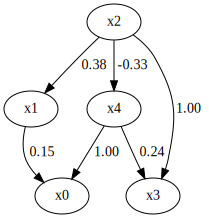

In [9]:
prior_knowledge = make_prior_knowledge(
    n_variables=5,
    exogenous_variables=[2],
)

model = lingam.LiM(prior_knowledge=prior_knowledge)
model.fit(X, dis_con)

make_dot(model.adjacency_matrix_)